In [84]:
import numpy as np
import matplotlib.pyplot as plt

In [85]:
text = ("the quick brown fox jumps over the lazy dog. " * 200).lower()
chars = list(set(text))
vocab_size = len(chars)
char_to_ix = {c:i for i,c in enumerate(chars)}
data = [char_to_ix[c] for c in text]

In [86]:
class RNN:
    def __init__(self, hidden_size, rho):
        self.h_size = hidden_size
        self.Wxh = np.random.randn(hidden_size, vocab_size) / np.sqrt(vocab_size)
        self.Whh = np.random.randn(hidden_size, hidden_size) / np.sqrt(hidden_size)
        self.Why = np.random.randn(vocab_size, hidden_size) / np.sqrt(hidden_size)
        self.Whh *= rho
        self.bh = np.zeros((hidden_size,1))
        self.by = np.zeros((vocab_size,1))

def softmax(x):
    e = np.exp(x - np.max(x))
    return e / np.sum(e)

In [87]:
def train_network(steps, rho, lr=0.01):
    rnn = RNN(hidden_size=50, rho=rho)
    seq_length = 50
    grad_norms = []

    p = 0
    hprev = np.zeros((50,1))

    for step in range(steps):
        if p + seq_length + 1 >= len(data) or step == 0:
            hprev = np.zeros((50,1))
            p = 0

        xs, hs, ys, ps = {}, {}, {}, {}
        hs[-1] = hprev

        # ----- Forward (ReLU) -----
        for t in range(seq_length):
            xs[t] = np.zeros((vocab_size,1))
            xs[t][data[p+t]] = 1
            hs[t] = np.maximum(0, rnn.Wxh @ xs[t] + rnn.Whh @ hs[t-1] + rnn.bh)  # ReLU
            ys[t] = rnn.Why @ hs[t] + rnn.by
            ps[t] = softmax(ys[t])

        # ----- Backward -----
        dWxh, dWhh, dWhy = np.zeros_like(rnn.Wxh), np.zeros_like(rnn.Whh), np.zeros_like(rnn.Why)
        dbh, dby = np.zeros_like(rnn.bh), np.zeros_like(rnn.by)
        dhnext = np.zeros_like(hprev)

        for t in reversed(range(seq_length)):
            dy = ps[t].copy()
            dy[data[p+t+1]] -= 1
            dWhy += dy @ hs[t].T
            dby += dy
            dh = rnn.Why.T @ dy + dhnext
            dhraw = (hs[t] > 0) * dh          # ReLU derivative
            dbh += dhraw
            dWxh += dhraw @ xs[t].T
            dWhh += dhraw @ hs[t-1].T
            dhnext = rnn.Whh.T @ dhraw

        grad_norms.append(np.linalg.norm(dWhh))

        for param, dparam in zip([rnn.Wxh, rnn.Whh, rnn.Why, rnn.bh, rnn.by],
                                 [dWxh, dWhh, dWhy, dbh, dby]):
            param -= lr * dparam

        p += seq_length
        hprev = hs[seq_length-1]

    return grad_norms

In [88]:
print("Training Vanishing case...")
grads_vanish = train_network(steps=200, rho=0.9, lr=0.0001)

print("Training Exploding case...")
grads_explode = train_network(steps=200, rho=1.2, lr=0.0001)

print("Training Stable case...")
grads_stable = train_network(steps=200, rho=0.99, lr=0.0001)

Training Vanishing case...
Training Exploding case...
Training Stable case...


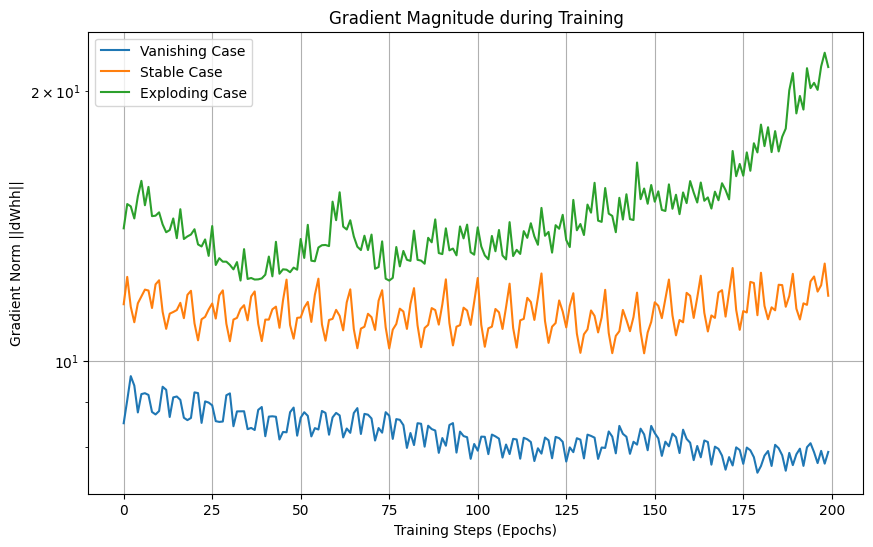

In [89]:
plt.figure(figsize=(10, 6))
plt.plot(grads_vanish, label='Vanishing Case')
plt.plot(grads_stable, label='Stable Case')
plt.plot(grads_explode, label='Exploding Case')
plt.yscale('log')
plt.xlabel('Training Steps (Epochs)')
plt.ylabel('Gradient Norm ||dWhh||')
plt.title('Gradient Magnitude during Training')
plt.legend()
plt.grid(True)
plt.show()
